# Project 1: Exploratory Data Analysis of Movie Data
### By Amelia Dahm & Khyatee Desai<br>Oct. 2nd, 2020


## Import Python Libraries

In [53]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
%matplotlib inline

## Read in CSV Files

In [54]:
movie_gross_raw = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
tmdb_raw = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
budgets_raw = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
characters_raw = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')

# Question 1: Which Movies Genres are Most Successful?
This question investigates which movie genres are most successful, through different measures of "success" beyond gross revenue. Academy Award nominations are widely accepted as a reliable measure of a film's quality, so we decided to include Oscar Nomination data in the analysis.<br>
If the data suggests that certain movie genres tend to receive more nominations or generate a higher gross revenue, "Microsoft" should invest more in producing films of those genres.

## Method:

##  Read in Oscars Dataset
The Oscars dataset contains information on cast, crew, and movie titles of Oscar-nominated films.<br>Source: https://www.kaggle.com/unanimad/the-oscar-award

In [55]:
oscars_raw = pd.read_csv('./zippedData/oscars.zip', encoding = "ISO-8859-1")
oscars_raw.head(3)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False


<br>

## Get the Count of Oscar Nominations Per Movie

In [56]:
# subset the relevant data from Oscars df. Rename columns, drop rows with no movie title
oscars = oscars_raw.loc[:,['film','name', 'category']]
oscars.rename(columns={'film': 'title', 'name': 'person'}, inplace=True)
oscars.drop(oscars[oscars['title'].isnull()].index, inplace=True)


# create column for total number of oscar nominations per movie
counts = oscars['title'].value_counts()
d = counts.to_dict()
oscars['oscar_noms'] = oscars['title'].map(d)
oscars.head(3)

,title,person,category,oscar_noms
0,The Noose,Richard Barthelmess,ACTOR,1
1,The Last Command,Emil Jannings,ACTOR,2
2,A Ship Comes In,Louise Dresser,ACTRESS,1


<br>

## Reshape the Genre values
Genres were originally formatted as a comma-delimited string (ie 'Action, Crime, Drama'.) We reformatted this to give each genre its own row in the table.

In [57]:
# Unstacking Genre column to create individual rows (takes a while to run cell)
genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('primary_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['primary_title', 'genres']
genre_unstack.head(3)

,primary_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama


<br>

## Merge Oscars table with Genre table

In [58]:
oscar_genre = oscars.merge(genre_unstack, how = 'left', left_on='title', right_on='primary_title').drop('primary_title', axis=1)
oscar_genre.head(3)

,title,person,category,oscar_noms,genres
0,The Noose,Richard Barthelmess,ACTOR,1,Documentary
1,The Last Command,Emil Jannings,ACTOR,2,NaN
2,A Ship Comes In,Louise Dresser,ACTRESS,1,NaN


<br>

## Clean Gross Revenue Table

In [59]:
# subset relevant data, change strings to floats
movie_gross = movie_gross_raw.loc[:, ['title', 'domestic_gross', 'foreign_gross']]
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','').astype(float)
movie_gross['total_gross'] = movie_gross.domestic_gross + movie_gross.foreign_gross
movie_gross.head(3)

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000.0,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0,9.603000e+08


<br>

 ## Clean Budgets Table

In [60]:
# subset relevant data, change strings to floats
budgets = budgets_raw.loc[:,['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']]
budgets.rename(columns={'movie': 'title', 'worldwide_gross':'total_gross'}, inplace=True)
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','').astype(float)
budgets['total_gross'] = budgets['total_gross'].str.replace('$','')
budgets['total_gross'] = budgets['total_gross'].str.replace(',','').astype(float)
budgets.head(3)

,title,production_budget,domestic_gross,total_gross
0,Avatar,425000000.0,760507625.0,2.776345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08


<br>

## Concatenate Gross Revenue Table with Budgets Table

In [61]:
# concat gross and budget tables, create columns for total_gross and Return on Investment, drop duplicate rows
budget_concat = pd.concat([movie_gross, budgets], sort=True)
budget_concat['roi'] = (((budget_concat.total_gross - budget_concat.production_budget)/budget_concat.production_budget)* 100).round(2)
budget_concat.drop_duplicates(subset=['title'],keep='last', inplace=True)
budget_concat.sample(3)

,domestic_gross,foreign_gross,production_budget,title,total_gross,roi
2812,15285588.0,NaN,18000000.0,Youth in Revolt,19685588.0,9.36
2312,1190003.0,NaN,25000000.0,Me and Orson Welles,1190003.0,-95.24
4323,8886160.0,NaN,5000000.0,Saved!,10206551.0,104.13


<br>

## Final Oscar Nominations, Genre, and Budget DataFrame
This is the table used as the starting point for the analysis below. Null values are retained in this table, but dropped below based on the specific metrics being compared.

In [62]:
# subset the oscars table, drop duplicate listings
oscar_df = oscar_genre.loc[:,['title', "oscar_noms", 'genres']]
oscar_df.drop_duplicates(inplace=True)

# merged genre/oscar table with budgets (used Left Join to retain all Oscar data)
oscar_df = oscar_df.merge(budget_concat[['title','production_budget', "total_gross", 'roi']], on='title', how='left').set_index('title')
oscar_df.sort_values('oscar_noms', ascending=False)

,oscar_noms,genres,production_budget,total_gross,roi
title,,,,,
A Star Is Born,25,Romance,NaN,NaN,NaN
A Star Is Born,25,Drama,NaN,NaN,NaN
A Star Is Born,25,Music,NaN,NaN,NaN
Titanic,16,Family,200000000.0,2.208208e+09,1004.10
Titanic,16,Adventure,200000000.0,2.208208e+09,1004.10
...,...,...,...,...,...
Evolution,1,Mystery,80000000.0,9.834193e+07,22.93
Evolution,1,Drama,80000000.0,9.834193e+07,22.93
The Crunch Bird,1,NaN,NaN,NaN,NaN


<br>

# Question 1 Analysis 

## Oscar Nominations vs. Total Gross Revenue
#### This figure plots films' total gross revenue against their Oscar nomination count. There is a slight positive correlation, indicating a relationship between gross revenue and number of nominations. This loosely suggests that higher grossing films tend to get more Oscar nominations.

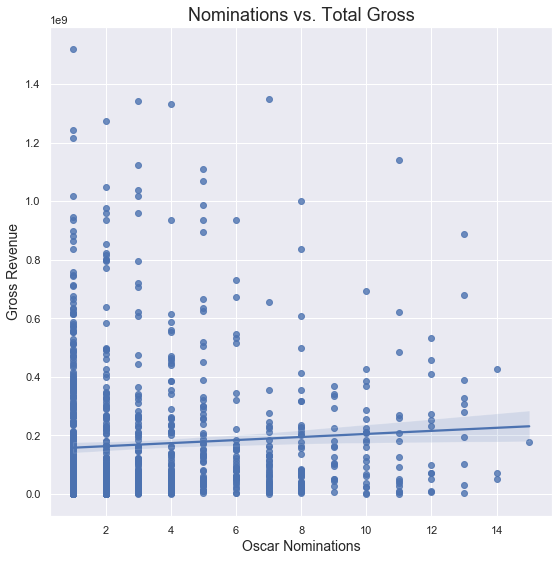

In [63]:
x ='oscar_noms'
y = 'total_gross'

# drop duplicates, nulls values, and 3 outliers with highest Total Gross Revenue (Avatar, Titanic, and Avengers: Infinity War)
noms_vs_budget = oscar_df.loc[:,[x, y]].drop_duplicates().sort_values(y).dropna(subset=['total_gross'])[:-3] 

sns.set(rc={'figure.figsize':(9,9)});
sns.regplot(x,y, data = noms_vs_budget);
plt.title('Nominations vs. Total Gross',fontsize=18);
plt.xlabel('Oscar Nominations', fontsize=14);
plt.ylabel('Gross Revenue', fontsize=14);

<br>

## Removing Gross Revenue Outliers

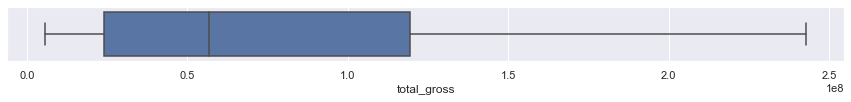

In [64]:
# drop outliers by excluding upper quartile
gross = oscar_df[oscar_df["total_gross"].between(*oscar_df.total_gross.quantile([0.1, 0.75]).tolist())]

# check boxplot to verify outliers are gone
sns.set(rc={'figure.figsize':(15,1)});
sns.boxplot(data=gross, x='total_gross');

<br>

## Total Gross Revenue, By Genre
#### This figure plots total gross revenue, summed and grouped by genre. The top three grossing genres from the data are Drama, Comedy, and Biographies. This suggests that these three genres tend to generate the most revenue.

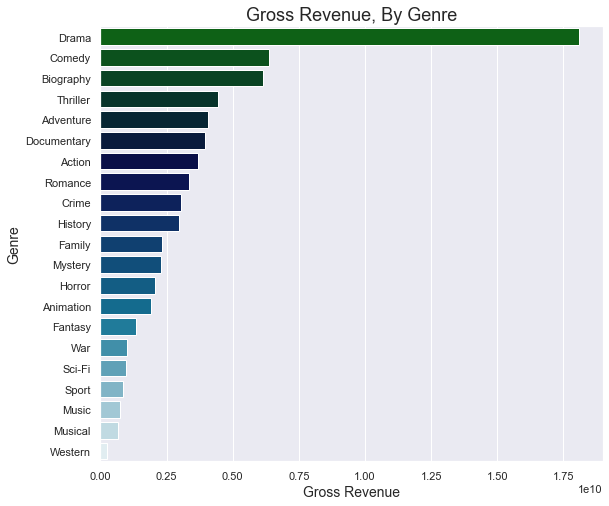

In [65]:
genre_gross = gross.groupby(['genres'])['total_gross'].sum().reset_index().sort_values('total_gross', ascending=False)

sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('total_gross','genres' , data = genre_gross, order= genre_gross['genres'], palette='ocean');
plot.set_title('Gross Revenue, By Genre',fontsize=18);
plt.xlabel('Gross Revenue', fontsize=14);
plt.ylabel('Genre', fontsize=14);

<br>

## Oscar Nominations, By Genre
#### This figure plots Oscar nomination count, summed and grouped by genre. The three genres from the data with the highest number of Oscar nominations are Drama, Documentary, and Comedy. This suggests that films falling into these three genres tend to get nominated the most for Oscar awards.

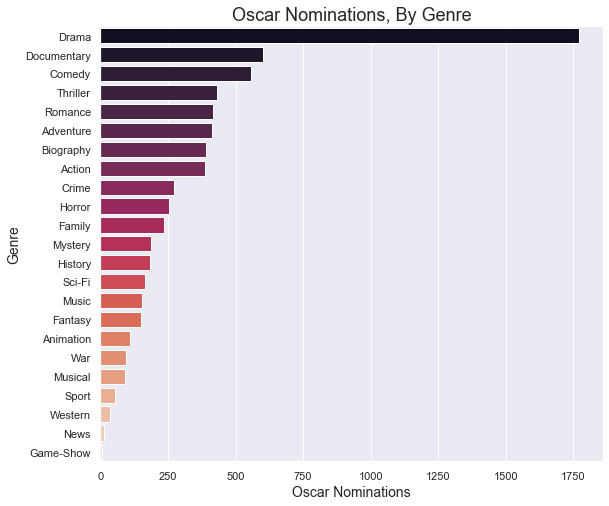

In [14]:
genre_noms = oscar_df.groupby(['genres'])['oscar_noms'].sum().reset_index().sort_values('oscar_noms', ascending=False)

sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('oscar_noms','genres' , data = genre_noms, order= genre_noms['genres'], palette='rocket');
plot.set_title('Oscar Nominations, By Genre',fontsize=18);
plt.xlabel('Oscar Nominations', fontsize=14);
plt.ylabel('Genre', fontsize=14);

<br>

## Question 1 Conclusion: 
### The above analysis suggests that two genres, Dramas and Comedies, historically perform the best in both criteria of successful movies that we measured (gross revenue and Oscar nominations.) Based on this, our recommendation to Microsoft is to produce Dramas and Comedies for the most success at the Box Office and at the Academy Awards.

<br>

# Question 2: How does Trailer Popularity Impact Movie Success?
This question explores the relationship between movie budget, and Box Office success. A portion of movie budget is spent on marketing efforts, such as the movie trailer. If there is a relationship between movie trailer popularity and Box Office success, this could indicate that marketing effors (such as movie trailers) have a significant impact on revenue, and that "Microsoft" should place a higher importance on investing resources into movie trailers for their future movies.

## Method:

## Read in Movie Trailer CSV
The movie trailer dataset includes movie titles and YouTubeID's corresponding to the film's trailer on YouTube.<br>Source: https://grouplens.org/datasets/movielens/20m-youtube/

In [15]:
# slice year out of title string, merge with budgets table
trailers_raw = pd.read_csv('./zippedData/movie_trailers.zip')
trailers_raw['title'] = trailers_raw['title'].str[:-7]
trailers = trailers_raw.merge(budget_concat, on='title').sort_values('total_gross', ascending=False) #### remove this later
ids = list(trailers["youtubeId"].values[:])
trailers.head()

,youtubeId,movieId,title,domestic_gross,foreign_gross,production_budget,total_gross,roi
2745,5MB3Ea6L-gw,72998,Avatar,760507625.0,NaN,425000000.0,2.776345e+09,553.26
458,dQ7MAigAhas,3404,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
457,2e-eXJ6HgkQ,1721,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
459,yxIVO7P0iig,118916,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
2798,tck0UR2ppjg,82452,Frozen,400738009.0,NaN,150000000.0,1.272470e+09,748.31


<br>

## Function Passes in YouTube ID's of Trailers and Scrapes Number of Views

In [16]:
def getViews(youtubeIDs):
    views = []
    for i in youtubeIDs:
        try:
            url = "https://www.youtube.com/watch?v={}".format(i)
            html_page = requests.get(url) 
            soup = BeautifulSoup(html_page.text, 'html.parser')
            script = soup.find_all('script')[32]
            value = re.findall('ewCount":{"simpleText":"([\d,]+) views', str(soup))
            views.append(float(value[0].replace(',','')))
        except:
            views.append(0)
    return views


<br>

## Scrape all YouTube Trailers and Save View Counts as CSV <br>(*Warning: takes ~1hr to run*)
### Leave this commented out

In [17]:
# trailers['trailer_views'] = getViews(ids)
# trailers.to_csv('zippedData/trailerViews.csv')

<br>

# Construct Final Trailer Views, ROI DataFrame

In [18]:
# sort by trailer views and drop duplicates to keep only trailer with highest views
trailer_df = pd.read_csv('zippedData/trailerViews.csv')
trailer_df = trailer_df.loc[:,['title','youtubeId','production_budget', 'total_gross', 'roi', 'trailer_views']].sort_values('trailer_views', ascending=False)
trailer_df = trailer_df.drop_duplicates(subset= ['title'], keep='first').set_index('title')
trailer_df.sample(3)

,youtubeId,production_budget,total_gross,roi,trailer_views
title,,,,,
In the Shadow of the Moon,h9d9-pHZzIE,2000000.0,2175587.0,8.78,161740.0
Return to Oz,CklyKCKFtwE,27000000.0,10618813.0,-60.67,0.0
Sublime,PwJz18hwzi0,1800000.0,0.0,-100.00,150529.0


<br>

## Production Budget vs. Return on Investment
#### This figure plots movie production budget against the return on investment. There is a slight positive correlation, indicating that movies with a higher production budget tend to bring a higher return on investment.

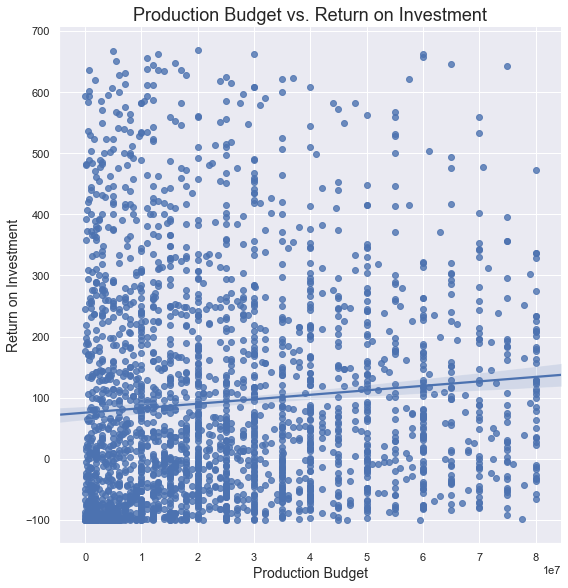

In [19]:
# drop outliers
roi_no_outliers = trailer_df[trailer_df["roi"].between(*trailer_df['roi'].quantile([0, 0.9]).tolist())]
budget_no_outliers = roi_no_outliers[roi_no_outliers["production_budget"].between(*roi_no_outliers['production_budget'].quantile([0, 0.9]).tolist())]

plot =sns.lmplot('production_budget','roi',data = budget_no_outliers, height=8, truncate=False, fit_reg=True);
plt.title('Production Budget vs. Return on Investment',fontsize=18);
plt.xlabel('Production Budget', fontsize=14);
plt.ylabel('Return on Investment', fontsize=14);

<br>

## Trailer Views vs. Gross Revenue
#### This figure plots movie trailer view count against total gross revenue. The data has a slight positive correlation, indicating a relationship between movie trailer views and revenue. This suggests that movies with highly-viewed trailers on YouTube tend to have higher gross revenues.

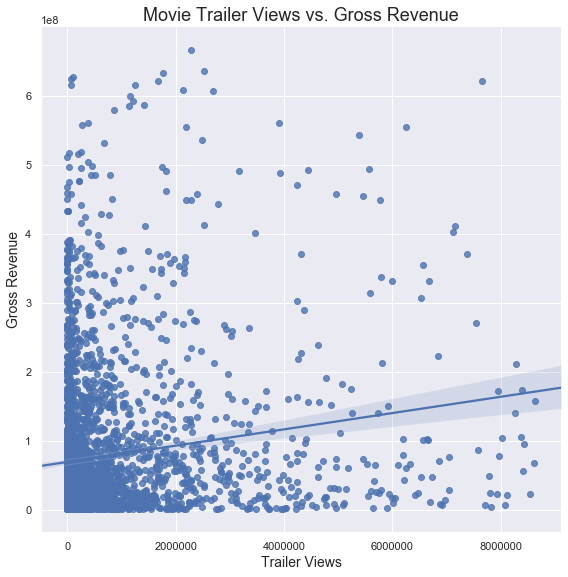

In [20]:
# drop outliers
trailer_no_outliers = trailer_df[trailer_df["trailer_views"].between(*trailer_df['trailer_views'].quantile([0.1, 0.97]).tolist())]
gross_no_outliers = trailer_no_outliers[trailer_no_outliers["total_gross"].between(*trailer_no_outliers['total_gross'].quantile([0.1, 0.99]).tolist())]


g = sns.lmplot('trailer_views', 'total_gross', data = gross_no_outliers, truncate=False,height = 8);
# g.set(xscale="log", yscale="log")
plt.title('Movie Trailer Views vs. Gross Revenue',fontsize=18);
plt.xlabel('Trailer Views', fontsize=14);
plt.ylabel('Gross Revenue', fontsize=14);

<br>

## Question 2: Conclusion
### The above analysis indicates that there is a positive relationship between production budget & ROI, and more specifically, a positive relationship between movie trailer views & revenue. This suggests that movies that invest more into production and marketing efforts such as movie trailers, tend to see more success at the Box Office. Based on this analysis, our recommendation to Microsoft is to invest resources into their marketing efforts, such as movie trailers.

# Question 3: Do Music Scores Contribute to Movie Success?


The purpose of this question is to gain actionable insights on how the movie soundtrack impacts its success. The quality of the music a movie uses could make a strong impression on viewers. If choosing memorable music and influencial composers can increase success, more of the budget should be allocated toward its composure. 


## Method:






## Scrape Music Reviews Page
Source: http://www.movie-wave.net/reviews-by-title/
<br>This dataset includes information on movie titles, composers, year, and the music score. The music score was assigned by American songwriter and musician, James Southall.

In [21]:
# Grab data within the page-content class
time.sleep(5)
page = requests.get("http://www.movie-wave.net/reviews-by-title/")
soup = BeautifulSoup(page.content, 'html.parser')
content = soup.find('div', class_="page-content")
p_list = content.findAll('p') # tag where data is located

In [22]:
# Creating a list of lists
# Finding the title, composer, year, and score
to_df =[]
for p in p_list:
    for a in p.findAll('a'):
        try:
           to_df.append([a.text, a.nextSibling, a.nextSibling.nextSibling.text])
        except:
            pass

<br>

## Construct Music Rating DataFrame

In [23]:
# Set up dataframe for scraper to go into
music_df = pd.DataFrame(to_df, columns=['title', 'composer', 'stars'])
music_df['composer'] = music_df['composer'].str[:-7]

In [24]:
# Convert astris to numerical value
stars = list(music_df['stars'])
mapper = {'*****':5, '**** 1/2':4.5,'****':4,'*** 1/2':3.5,'***':3,'** 1/2':2.5,'**':2,'* 1/2':1.5,'*':1}
ratings = list(map(mapper.get, stars))
music_df['music_rating'] = ratings
music_df = music_df.drop('stars',axis=1)
music_df.head(3)

,title,composer,music_rating
0,10 Cloverfield Lane,Bear McCreary,4.0
1,100 Rifles,Jerry Goldsmith,4.0
2,101 Dalmatians,Michael Kamen,4.5


<br>

## Compile IMDB, TMDB, and Music Ratings with Financial Data


In [25]:
# tmdb merge with finances
tmdb = tmdb_raw.merge(budget_concat[['title', 'total_gross','production_budget', 'roi']], on='title', how='left')
tmdb.rename(columns ={'popularity':'tmdb_popularity', 'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'}, inplace=True)
tmdb = tmdb.loc[:,['title', 'tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi']]
tmdb

,title,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,33.533,NaN,NaN,NaN
1,How to Train Your Dragon,7.7,7610,28.734,494870992.0,165000000.0,199.92
2,Iron Man 2,6.8,12368,28.515,621156389.0,170000000.0,265.39
3,Toy Story,7.9,10174,28.005,364545516.0,30000000.0,1115.15
4,Inception,8.3,22186,27.920,835524642.0,160000000.0,422.20
...,...,...,...,...,...,...,...
26512,Laboratory Conditions,0.0,1,0.600,NaN,NaN,NaN
26513,_EXHIBIT_84xxx_,0.0,1,0.600,NaN,NaN,NaN
26514,The Last One,0.0,1,0.600,NaN,NaN,NaN
26515,Trailer Made,0.0,1,0.600,NaN,NaN,NaN


In [26]:
# Adding in imdb dataframe
imdb = imdb_raw.merge(titles_raw,left_on ='tconst', right_on ='title_id')
imdb.rename(columns ={'averagerating':'imdb_rating', 'numvotes': 'imdb_votes'}, inplace=True)
imdb = imdb[['title', 'imdb_rating', 'imdb_votes' ]]
ratings = imdb.merge(tmdb, on='title', how='left')
ratings.sample(3)

,title,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
191214,Desautorizados,5.2,23,NaN,NaN,NaN,NaN,NaN,NaN
101261,Jane,7.8,3018,6.0,1.0,1.8,NaN,NaN,NaN
41249,Merry-Go-Round,6.6,650,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
final_music = music_df.merge(ratings, on='title', how='inner')
final_music.sample(3)

,title,composer,music_rating,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
663,Carrie,Pino Donaggio,4.5,5.9,125424,7.1,1766.0,9.467,25878153.0,1800000.0,1337.68
3438,Robin Hood,Marc Streitenfeld,2.0,6.6,239480,5.7,3.0,0.680,84747441.0,99000000.0,-14.40
2939,Operation Finale,Alexandre Desplat,3.5,6.5,20927,6.7,282.0,13.692,NaN,NaN,NaN


In [28]:
# drop columns with high amount of null values
music_imdb = final_music.drop(['tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi'], axis=1)
music_imdb.dropna(inplace=True)
music_imdb.sample(3)

,title,composer,music_rating,imdb_rating,imdb_votes
702,The Challenge,Jerry Goldsmith,3.5,9.0,11
2166,Iris,James Horner,3.0,6.1,2443
2128,Inferno,Hans Zimmer,3.0,5.7,742


<br>

## Clean Movie Budget DataFrame and Compute ROI

In [29]:
gross = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
gross['year'] = gross['release_date'].str[-4:].astype(float)
gross['domestic_gross'] = gross['domestic_gross'].str.replace(',', '')
gross['domestic_gross'] = gross['domestic_gross'].str.replace('$', '').astype(float)
gross['production_budget'] = gross['production_budget'].str.replace(',', '')
gross['production_budget'] = gross['production_budget'].str.replace('$', '').astype(float)
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace(',', '')
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace('$', '').astype(float)

In [30]:
gross['ROI'] = (((gross['worldwide_gross'] - gross['production_budget']) / gross['production_budget'] ) * 100)

In [31]:
# renaming and setting index for merging purposes
gross.rename(columns = {'movie': 'original_title'}, inplace=True)
gross.set_index('original_title')

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,ROI
original_title,,,,,,,
Avatar,1,"Dec 18, 2009",425000000.0,760507625.0,2.776345e+09,2009.0,553.257713
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000.0,241063875.0,1.045664e+09,2011.0,154.667286
Dark Phoenix,3,"Jun 7, 2019",350000000.0,42762350.0,1.497624e+08,2019.0,-57.210757
Avengers: Age of Ultron,4,"May 1, 2015",330600000.0,459005868.0,1.403014e+09,2015.0,324.384139
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000.0,620181382.0,1.316722e+09,2017.0,315.369636
...,...,...,...,...,...,...,...
Red 11,78,"Dec 31, 2018",7000.0,0.0,0.000000e+00,2018.0,-100.000000
Following,79,"Apr 2, 1999",6000.0,48482.0,2.404950e+05,1999.0,3908.250000
Return to the Land of Wonders,80,"Jul 13, 2005",5000.0,1338.0,1.338000e+03,2005.0,-73.240000


<br>

## Stack Genre DataFrame and Merge with Financial Data

In [32]:
# reimported raw dataset that was manipulated in the question above
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw

genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('original_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['original_title', 'genres']

In [33]:
# Merge with budget table and remove null values
genre_roi = genre_unstack.merge(gross[['original_title', 'ROI']], on='original_title', how='left')
genre_roi.dropna(axis = 0, inplace = True)

<br>

## Compile for Composer Dataframe

In [34]:
# stack column listing movie id for each crew member
crew = crew_raw
crew['directors'] = crew['directors'].str.split(',', 5)
crew_unstack = crew.set_index('tconst').directors.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
crew_unstack.columns = ['tconst', 'id']

In [35]:
# stack column listing professions for each crew member
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw.rename(columns = {'nconst' : 'directors', 'title_id':'tconst'}, inplace=True)
name_basics_raw

name_basics = name_basics_raw
name_basics['primary_profession'] = name_basics['primary_profession'].str.split(',', 5)
name_basics_unstack = name_basics.set_index('directors').primary_profession.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()

In [36]:
# Rename dataframes
name_basics_unstack.columns = ['id', 'job_title']
name_basics.rename(columns={'directors':'id'}, inplace=True)

In [37]:
# Pulling in Data and Matching indices to Merge
titles_raw.rename(columns = {'title_id':'tconst', 'title' : 'original_title'}, inplace=True)

In [38]:
# Merge Title into Genre + ROI
roi_with_title = genre_roi.merge(titles_raw[['original_title', 'tconst']], on='original_title', how='inner')

In [39]:
# Filter for Composers
composer = name_basics_unstack[name_basics_unstack['job_title'] == 'composer']

In [40]:
# Merge with crew by ID
composers = crew_unstack.merge(composer[['id', 'job_title']], on='id', how='left')
composers.dropna(inplace=True)
composers.set_index('id', inplace=True)

In [41]:
# Use ID to grab composers name
composers_names = composer.merge(name_basics[['id', 'primary_name']], on='id', how='left')
composers_names.set_index('primary_name')

,id,job_title
primary_name,,
Joseph Bauer,nm0061865,composer
Stevie Be-Zet,nm0063432,composer
Jeff Beal,nm0063618,composer
Gavin Bellour,nm0069225,composer
Jorge Ben Jor,nm0069990,composer
...,...,...
Oscar Martorell,nm9786484,composer
Shine Issai,nm9927305,composer
Ifthi,nm9942831,composer


In [42]:
# Grab movie id
crew = crew_unstack.merge(name_basics_raw[['id', 'primary_name']], on='id', how='left')

In [43]:
# Add in genre
roi_crew_genre = roi_with_title.merge(crew[['tconst', 'primary_name']], on='tconst', how='left')
roi_crew_genre.drop_duplicates(inplace=True)
roi_crew_genre.set_index('primary_name')

,original_title,genres,ROI,tconst
primary_name,,,,
Lawrence Kasanoff,Foodfight!,Action,-99.836209,tt0249516
Lawrence Kasanoff,Foodfight!,Animation,-99.836209,tt0249516
Lawrence Kasanoff,Foodfight!,Comedy,-99.836209,tt0249516
Simon McQuoid,Mortal Kombat,Action,510.666135,tt0293429
Simon McQuoid,Mortal Kombat,Adventure,510.666135,tt0293429
...,...,...,...,...
Gijsbert Tukker,Darkness,Sci-Fi,224.615151,tt4341750
Jug Radivojevic,Darkness,Sci-Fi,224.615151,tt3961040
Susanna White,Traitor,Action,26.737391,tt1995390


In [44]:
# Add names to roi + crew names + genre
composer_ = roi_crew_genre.merge(composers_names[['job_title', 'primary_name']], on='primary_name', how='inner')

In [45]:
# Final DataFrame
composer_df = composer_.merge(imdb_raw[['tconst', 'averagerating']], on='tconst', how='left')
composer_df.rename(columns={'primary_name': 'composer'}, inplace=True)
composer_df.set_index('composer', inplace=True)

In [46]:
# # Dropping null rating values
composer_df.dropna(inplace=True)

<br>

## Removing Music Rating Outliers

In [47]:
music_imdb

,title,composer,music_rating,imdb_rating,imdb_votes
0,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383
1,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383
2,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383
3,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383
4,10 Cloverfield Lane,Bear McCreary,4.0,7.2,260383
...,...,...,...,...,...
4487,Zootopia,Michael Giacchino,2.0,8.0,383446
4488,Zootopia,Michael Giacchino,2.0,8.0,383446
4489,Zootopia,Michael Giacchino,2.0,8.0,383446
4490,Zootopia,Michael Giacchino,2.0,8.0,383446


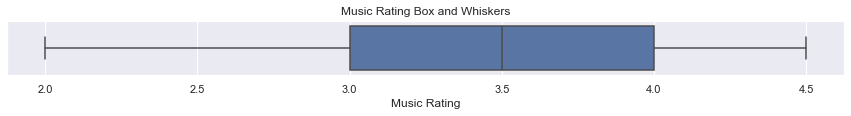

In [48]:
# drop outliers 
rating_plot = music_imdb[music_imdb["music_rating"].between(*music_imdb.music_rating.quantile([0.1, 0.9]).tolist())]

# check boxplot to verify outliers are gone
sns.set(rc={'figure.figsize':(15,1)});
sns.boxplot(data=rating_plot, x='music_rating');

# Labels
plt.title('Music Rating Box and Whiskers');
plt.xlabel('Music Rating');

##  The Relationship Between IMDB Movie Score and Music Rating
### There is a weak positive correlation between music ratings and the imdb movie ratings. This indicates that if a movie has a higher music rating, it is slightly more likely to recieve a higher movie rating from IMDB.

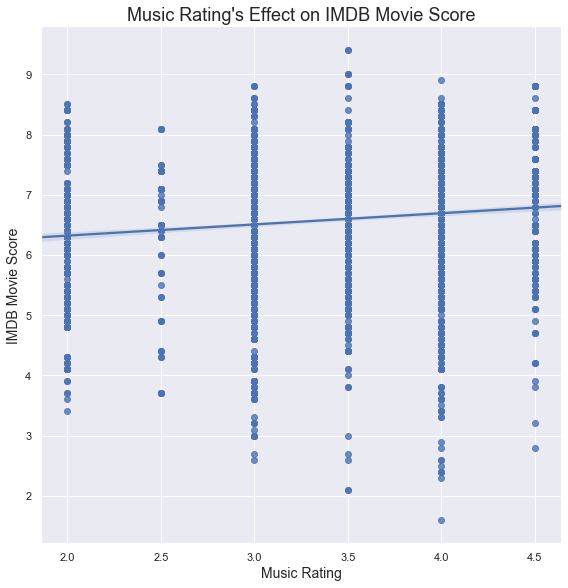

In [49]:
# Create lmplot using seaborn

sns.lmplot('music_rating','imdb_rating',  data = rating_plot, truncate=False, height=8);
plt.title("Music Rating's Effect on IMDB Movie Score",fontsize=18);

# Set Labels
plt.xlabel('Music Rating', fontsize=14);
plt.ylabel('IMDB Movie Score', fontsize=14);


<br>

##  The Top 25 Music Composers for Movies
### Below is a visualization depicting the top 25 composers imdb movie rating score. Adam Shaw is the highest with a score of 8.6. The lowest scoring composer recieved a 3.6. In conclusion, investing in a composer with a succesful work history can make a substantial on the movie's imdb movie rating. 

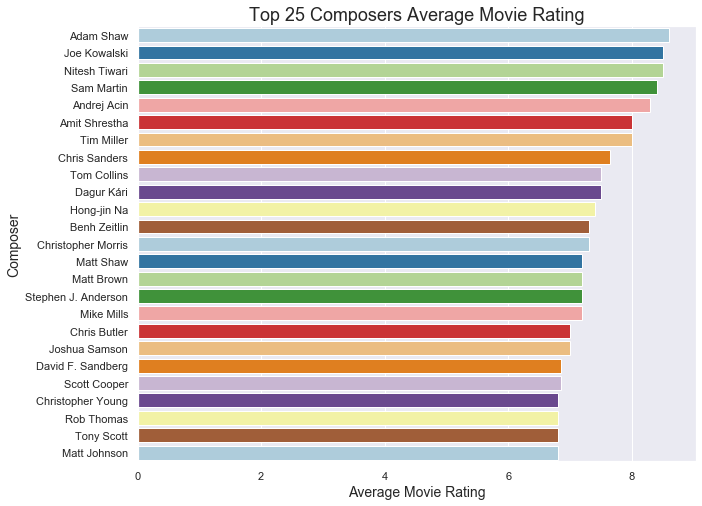

In [50]:
# create horizontal barplot using seaborn
composer_df_plt = composer_df.groupby(['composer'])['averagerating'].mean().reset_index().sort_values('averagerating', ascending=False)[:25]

# Format Plot
sns.set(rc={'figure.figsize':(10,8)})
plot = sns.barplot('averagerating','composer' , data = composer_df_plt, order= composer_df_plt['composer'], palette='Paired');

# Set Labels
plot.set_title('Top 25 Composers Average Movie Rating', fontsize=18);
plt.xlabel('Average Movie Rating', fontsize=14);
plt.ylabel('Composer', fontsize=14);


<br>

## Average ROI by Genre
### This visualization is represting what types of films are creating the highest amount of revenue.  The genre Musical's ROI is double nearly every other category. Musical adaptations are very common, and if "Microsoft" is looking to choose a genre, musical is a strong choice. 

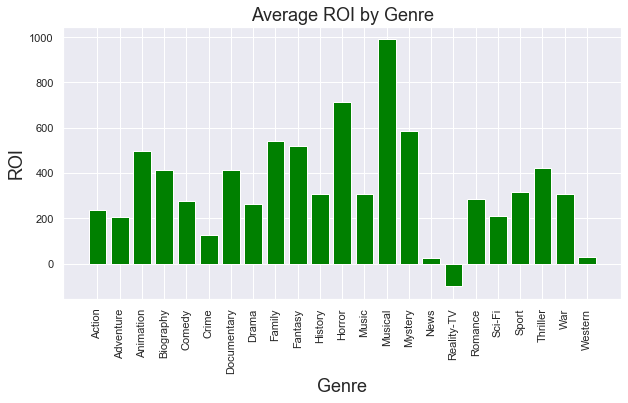

In [51]:
# Create bar plot using MatPltLib
y = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

figure, ax = plt.subplots(figsize = (10,5))

# Set Labels
ax.set_title('Average ROI by Genre', fontsize=18)
ax.set_xlabel('Genre', fontsize=18)
ax.set_ylabel('ROI', fontsize=18)
plt.xticks(rotation=90)

# Plot
ax.bar(x, y, color='green');

## Question 3: Conclusion
### In conclusion, the soundtrack in a movie can make an impact on movie's success if the soundtrack is produced by a composer with a reputable background. If the genre of the movie is musical, it is likely to obtain a high return on investment. Based on these findings, our recommendation to "Microsoft" is to invest resources into a reputable composer and a high quality music score.

<br>

# Conclusion and Next Steps

### In conclusion, we recommend "Microsoft" to stick with successful genres, create engaging trailers, and invest in well-established composers. 
### If we were to analyze further and go on to next steps, we would want to dive deeper into movie budgets. Figuring out how much to allocate towards movie trailers with high view counts and how much to spend to get crew members that cosistently recieve oscar nominations could help "Microsoft" make better business decisions.